**I(a)**


Test drive / Implement A Close, Pincer Search algorithm for CFI and MFI
mining and LFI mining algorithm. To the extent possible add features that
depict the trace or working of each of the algorithms for user-controlled
parameters such as Support, Confidence, etc.

**Logic used**

Implementing the Apriori and FP growth algorithms using inbuilt libraries.

**Packages used** 
* itertools
* numpy
* functools
* apyori
* pyfpgrowth

In [ ]:
#### CFI

from itertools import combinations

def generateClosures(transactions, generators):
        generators_trans_indices = [[] for _ in range(len(generators))]
        for trans_index, transaction in enumerate(transactions):
                for generator_index, generator in enumerate(generators):
                        if all(_item in transaction for _item in generator):
                                generators_trans_indices[generator_index].append(trans_index)
        generators_closures = []
        for generator_trans_indices in generators_trans_indices:
                if generator_trans_indices:
                        closure = transactions[generator_trans_indices[0]].copy()
                else:
                        closure = set()
                for trans_index in generator_trans_indices[1:]:
                        closure.intersection_update(transactions[trans_index])
                generators_closures.append(closure)
        return generators_closures


def generateCandidateItemsets(level_k, level_frequent_itemsets):
        n_frequent_itemsets = len(level_frequent_itemsets)
        candidate_frequent_itemsets = []
        for i in range(n_frequent_itemsets):
                j = i+1
                while (j<n_frequent_itemsets) and (level_frequent_itemsets[i][:level_k-1] == level_frequent_itemsets[j][:level_k-1]):
                        candidate_itemset = level_frequent_itemsets[i][:level_k-1] + [level_frequent_itemsets[i][level_k-1]] + [level_frequent_itemsets[j][level_k-1]]
                        candidate_itemset_pass = False
                        if level_k == 1:
                                candidate_itemset_pass = True
                        elif (level_k == 2) and (candidate_itemset[-2:] in level_frequent_itemsets):
                                candidate_itemset_pass = True
                        elif all((list(_)+candidate_itemset[-2:]) in level_frequent_itemsets for _ in combinations(candidate_itemset[:-2], level_k-2)):
                                candidate_itemset_pass = True
                        if candidate_itemset_pass:
                                candidate_frequent_itemsets.append(candidate_itemset)
                        j += 1
        return candidate_frequent_itemsets


def AClose(transactions, min_support, return_support_counts=False):
        items = set()
        for transaction in transactions:
                items.update(transaction)
        items = sorted(list(items))     
        generators = []
        level_k = 1
        prev_level_freq_itemsets_cnts = [] 
        candidate_frequent_itemsets = [[item] for item in items] 
        while candidate_frequent_itemsets:
                print("LEVEL {}:".format(level_k))               
                candidate_freq_itemsets_cnts = [0]*len(candidate_frequent_itemsets)
                for transaction in transactions:
                        for i, itemset in enumerate(candidate_frequent_itemsets):
                                if all(_item in transaction for _item in itemset):
                                        candidate_freq_itemsets_cnts[i] += 1
                print("C{}: ".format(level_k), end='')
                for itemset, support in zip(candidate_frequent_itemsets, candidate_freq_itemsets_cnts):
                        print("{} -> {}".format(itemset, support), end=', ')
                print()                
                level_frequent_itemsets_cnts = [(itemset,support) for itemset, support in zip(candidate_frequent_itemsets, candidate_freq_itemsets_cnts) if support >= min_support]
                print("L{}: ".format(level_k), end='')
                for itemset, support in level_frequent_itemsets_cnts:
                        print("{} -> {}".format(itemset, support), end=', ')
                print()
                print("Itemsets Pruned from L{}: ".format(level_k), end='')
                for level_freq_itemset, level_freq_itemset_sup in level_frequent_itemsets_cnts.copy():
                        for prev_level_freq_itemset, prev_level_freq_itemset_sup in prev_level_freq_itemsets_cnts:                               
                                if all(_item in level_freq_itemset for _item in prev_level_freq_itemset) and prev_level_freq_itemset_sup == level_freq_itemset_sup:
                                        print(level_freq_itemset, end=', ')
                                        level_frequent_itemsets_cnts.remove((level_freq_itemset, level_freq_itemset_sup))
                                        break
                print()
                print("L{} After Pruning: ".format(level_k), end='')
                for itemset, support in level_frequent_itemsets_cnts:
                        print("{} -> {}".format(itemset, support), end=', ')
                print()
                level_frequent_itemsets = [itemset for itemset,support in level_frequent_itemsets_cnts]
                candidate_frequent_itemsets = generateCandidateItemsets(level_k, level_frequent_itemsets)
                generators.extend(level_frequent_itemsets)
                level_k += 1
                prev_level_freq_itemsets_cnts = level_frequent_itemsets_cnts
                print()
        generators_closures = generateClosures(transactions, generators)
        closed_frequent_itemsets = []
        for generator_closure in generators_closures:
                if generator_closure not in closed_frequent_itemsets:
                        closed_frequent_itemsets.append(generator_closure)
        if return_support_counts == True:
            closed_frequent_itemsets_cnts = [0]*len(closed_frequent_itemsets)
            for transaction in transactions:
                    for i, itemset in enumerate(closed_frequent_itemsets):
                            if all(_item in transaction for _item in itemset):
                                closed_frequent_itemsets_cnts[i] += 1
            return closed_frequent_itemsets, closed_frequent_itemsets_cnts
        else:
            return closed_frequent_itemsets


if __name__ == '__main__':
        transactions = [
                {'1', '2', '3','4'},
                {'1', '3'},
                {'3', '4', '5'},
                {'2', '3'},
                {'3', '5', '4', '2'},
                {'4'}
        ]
        CFIs, CFI_cnts = AClose(transactions, 3, return_support_counts=True)
        print("Closed Frequent Itemsets (CFIs)")
        print("-------------------------------")
        for itemset, cnt in zip(CFIs, CFI_cnts):
            print("Itemset: {} Support count: {}".format(itemset, cnt))

LEVEL 1:
C1: ['1'] -> 2, ['2'] -> 3, ['3'] -> 5, ['4'] -> 4, ['5'] -> 2, 
L1: ['2'] -> 3, ['3'] -> 5, ['4'] -> 4, 
Itemsets Pruned from L1: 
L1 After Pruning: ['2'] -> 3, ['3'] -> 5, ['4'] -> 4, 

LEVEL 2:
C2: ['2', '3'] -> 3, ['2', '4'] -> 2, ['3', '4'] -> 3, 
L2: ['2', '3'] -> 3, ['3', '4'] -> 3, 
Itemsets Pruned from L2: ['2', '3'], 
L2 After Pruning: ['3', '4'] -> 3, 

Closed Frequent Itemsets (CFIs)
-------------------------------
Itemset: {'3', '2'} Support count: 3
Itemset: {'3'} Support count: 5
Itemset: {'4'} Support count: 4
Itemset: {'4', '3'} Support count: 3


In [ ]:
#### MFI

from itertools import combinations

def pruneCandidatesUsingMFS(candidate_itemsets, MFS):
  candidate_itemsets = candidate_itemsets.copy()
  for itemset in candidate_itemsets.copy():
    if any(all(_item in _MFS_itemset for _item in itemset) for _MFS_itemset in MFS):
      candidate_itemsets.remove(itemset)
  return candidate_itemsets


def generateCandidateItemsets(level_k, level_frequent_itemsets):
  n_frequent_itemsets = len(level_frequent_itemsets)
  candidate_frequent_itemsets = []
  for i in range(n_frequent_itemsets):
    j = i+1
    while (j<n_frequent_itemsets) and (level_frequent_itemsets[i][:level_k-1] == level_frequent_itemsets[j][:level_k-1]):
      candidate_itemset = level_frequent_itemsets[i][:level_k-1] + [level_frequent_itemsets[i][level_k-1]] + [level_frequent_itemsets[j][level_k-1]]
      candidate_itemset_pass = False
      if level_k == 1:
        candidate_itemset_pass = True
      elif (level_k == 2) and (candidate_itemset[-2:] in level_frequent_itemsets):
        candidate_itemset_pass = True
      elif all((list(_)+candidate_itemset[-2:]) in level_frequent_itemsets for _ in combinations(candidate_itemset[:-2], level_k-2)):
        candidate_itemset_pass = True
      if candidate_itemset_pass:
        candidate_frequent_itemsets.append(candidate_itemset)
      j += 1
  return candidate_frequent_itemsets


def pruneCandidatesUsingMFCS(candidate_itemsets, MFCS):
	candidate_itemsets = candidate_itemsets.copy()

	for itemset in candidate_itemsets.copy():
		if not any(all(_item in _MFCS_itemset for _item in itemset) for _MFCS_itemset in MFCS):
			candidate_itemsets.remove(itemset)

	return candidate_itemsets


def generateMFCS(MFCS, infrequent_itemsets):
  MFCS = MFCS.copy()
  for infrequent_itemset in infrequent_itemsets:
    for MFCS_itemset in MFCS.copy():
			# If infrequent itemset is a subset of MFCS itemset
      if all(_item in MFCS_itemset for _item in infrequent_itemset):
        MFCS.remove(MFCS_itemset)
        for item in infrequent_itemset:
          updated_MFCS_itemset = MFCS_itemset.copy()
          updated_MFCS_itemset.remove(item)
          if not any(all(_item in _MFCS_itemset for _item in updated_MFCS_itemset) for _MFCS_itemset in MFCS):
            MFCS.append(updated_MFCS_itemset)
  return MFCS


def pincerSearch(transactions, min_support):
  items = set()
  for transaction in transactions:
    items.update(transaction)
  items = sorted(list(items))
  level_k = 1 
  level_frequent_itemsets = [] 
  candidate_frequent_itemsets = [[item] for item in items] 
  level_infrequent_itemsets = [] 
  MFCS = [items.copy()] 
  MFS = [] 
  print("MFCS = {}".format(MFCS))
  print("MFS = {}\n".format(MFS))
  while candidate_frequent_itemsets:
    print("LEVEL {}: ".format(level_k))
    print("C{} = {}".format(level_k, candidate_frequent_itemsets))
    candidate_freq_itemsets_cnts = [0]*len(candidate_frequent_itemsets)
    MFCS_itemsets_cnts = [0]*len(MFCS)
    for transaction in transactions:
      for i, itemset in enumerate(candidate_frequent_itemsets):
        if all(_item in transaction for _item in itemset):
          candidate_freq_itemsets_cnts[i] += 1
      for i, itemset in enumerate(MFCS):
        if all(_item in transaction for _item in itemset):
          MFCS_itemsets_cnts[i] += 1
    for itemset, support in zip(candidate_frequent_itemsets, candidate_freq_itemsets_cnts):
      print("{} -> {}".format(itemset, support), end=', ')
    print()
    for itemset, support in zip(MFCS, MFCS_itemsets_cnts):
      print("{} -> {}".format(itemset, support), end=', ')
    print()
    MFS.extend([itemset for itemset, support in zip(MFCS, MFCS_itemsets_cnts) if ((support >= min_support) and (itemset not in MFS))])
    print("MFS = {}".format(MFS))
    level_frequent_itemsets = [itemset for itemset, support in zip(candidate_frequent_itemsets, candidate_freq_itemsets_cnts) if support >= min_support]
    level_infrequent_itemsets = [itemset for itemset, support in zip(candidate_frequent_itemsets, candidate_freq_itemsets_cnts) if support < min_support]
    print("L{} = {}".format(level_k, level_frequent_itemsets))
    print("S{} = {}".format(level_k, level_infrequent_itemsets))
    MFCS = generateMFCS(MFCS, level_infrequent_itemsets)
    print("MFCS = {}".format(MFCS))
    level_frequent_itemsets = pruneCandidatesUsingMFS(level_frequent_itemsets, MFS)
    print("After Pruning: L{} = {}\n".format(level_k, level_frequent_itemsets))
    candidate_frequent_itemsets = generateCandidateItemsets(level_k, level_frequent_itemsets)
    candidate_frequent_itemsets = pruneCandidatesUsingMFCS(candidate_frequent_itemsets, MFCS)
    level_k += 1
  return MFS


if __name__ == '__main__':
	transactions = [
		{1, 2, 3, 4},
		{1, 5, 3},
		{1, 5, 7},
		{4, 5},
		{5, 6, 8},
		{5, 6, 7},
		{5, 6, 7, 9},
		{2},
		{3},
		{3, 4, 7},
		{3, 4, 8},
		{5, 6, 9},
		{2, 4, 6, 9},
		{1, 3, 5, 7},
		{3, 5, 9},
	]

	min_support_count = 3
	MFS = pincerSearch(transactions, min_support_count)
	print("MFS = {}".format(MFS))

MFCS = [[1, 2, 3, 4, 5, 6, 7, 8, 9]]
MFS = []

LEVEL 1: 
C1 = [[1], [2], [3], [4], [5], [6], [7], [8], [9]]
[1] -> 4, [2] -> 3, [3] -> 7, [4] -> 5, [5] -> 9, [6] -> 5, [7] -> 5, [8] -> 2, [9] -> 4, 
[1, 2, 3, 4, 5, 6, 7, 8, 9] -> 0, 
MFS = []
L1 = [[1], [2], [3], [4], [5], [6], [7], [9]]
S1 = [[8]]
MFCS = [[1, 2, 3, 4, 5, 6, 7, 9]]
After Pruning: L1 = [[1], [2], [3], [4], [5], [6], [7], [9]]

LEVEL 2: 
C2 = [[1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 9], [2, 3], [2, 4], [2, 5], [2, 6], [2, 7], [2, 9], [3, 4], [3, 5], [3, 6], [3, 7], [3, 9], [4, 5], [4, 6], [4, 7], [4, 9], [5, 6], [5, 7], [5, 9], [6, 7], [6, 9], [7, 9]]
[1, 2] -> 1, [1, 3] -> 3, [1, 4] -> 1, [1, 5] -> 3, [1, 6] -> 0, [1, 7] -> 2, [1, 9] -> 0, [2, 3] -> 1, [2, 4] -> 2, [2, 5] -> 0, [2, 6] -> 1, [2, 7] -> 0, [2, 9] -> 1, [3, 4] -> 3, [3, 5] -> 3, [3, 6] -> 0, [3, 7] -> 2, [3, 9] -> 1, [4, 5] -> 1, [4, 6] -> 1, [4, 7] -> 1, [4, 9] -> 1, [5, 6] -> 4, [5, 7] -> 4, [5, 9] -> 3, [6, 7] -> 2, [6, 9] -> 3, [7, 9] -> 1, 

**Question I(b)**

Test drive or implement any one algorithm each for CFI, MFI which has not
been discussed in the class (Other than A-close and Pincer). You are free to
use any open-source available versions (eg. FIMI website etc.)

**Logic used:**

Mafia algorithm is used .


**Packages used:**
*   Numpy
*   Functools






In [ ]:
#### MAFIA Algo

import numpy as np
from functools import lru_cache

class TransVerticalBitmaps:
	def __init__(self, transactions):
		self.transactions = transactions
		self.n_transactions = len(self.transactions)
		items = set()
		for transaction in self.transactions:
			items.update(transaction)
		self.items = sorted(items)
		self.items_vertical_bitmaps = {item:np.zeros(shape=(self.n_transactions,), dtype=np.bool) for item in self.items}
		for i_transaction, transaction in enumerate(self.transactions):
			for item in transaction:
				self.items_vertical_bitmaps[item][i_transaction] = True


	@lru_cache(maxsize=32)
	def compVerticalBitmap(self, itemset):
		if len(itemset) == 1:
			item = itemset[0]
			return self.items_vertical_bitmaps[item]
		else:
			last_item = itemset[-1]
			return self.compVerticalBitmap(itemset[:-1])&self.items_vertical_bitmaps[last_item]


	def countSupport(self, itemset):
		itemset_vertical_bitmap = self.compVerticalBitmap(itemset)
		itemset_support_count = np.count_nonzero(itemset_vertical_bitmap)
		return itemset_support_count



class MafiaNode:
	def __init__(self, head, tail):
		self.head = head
		self.tail = tail.copy()


def _mafiaAlgorithm(current_node, MFIs, transactions, min_support_count):
	is_leaf = True
	for i, item in enumerate(current_node.tail):
		new_node_head = current_node.head + (item,)
		if transactions.countSupport(new_node_head) >= min_support_count:
			is_leaf = False
			new_node_tail = current_node.tail[i+1:]
			new_node = MafiaNode(new_node_head, new_node_tail)
			_mafiaAlgorithm(new_node, MFIs, transactions, min_support_count)
	if is_leaf and not any(all(item in mfi for item in current_node.head) for mfi in MFIs):
		MFIs.append(set(current_node.head))


def mafiaAlgorithm(transactions, min_support_count):
	transactions_vertical_bitmaps = TransVerticalBitmaps(transactions)
	MFIs = []
	mafia_cand_itemset_root = MafiaNode(tuple(), transactions_vertical_bitmaps.items)
	_mafiaAlgorithm(mafia_cand_itemset_root, MFIs, transactions_vertical_bitmaps, min_support_count)
	return MFIs


if __name__ == '__main__':
	transactions = [
		{1, 5, 6, 8},
		{2, 4, 8},
		{4, 5, 7},
		{2, 3},
		{5, 6, 7},
		{2, 3, 4},
		{2, 6, 7, 9},
		{5},
		{8},
		{3, 5, 7},
		{3, 5, 7},
		{5, 6, 8},
		{2, 4, 6, 7},
		{1, 3, 5, 7},
		{2, 3, 9},
	]

	min_support_count = 3
	MFIs = mafiaAlgorithm(transactions, min_support_count)
	print("Maximal Frequent Itemsets using MAFIA ")
	for mfi in MFIs:
		print(mfi)

Maximal Frequent Itemsets using MAFIA 
{2, 3}
{2, 4}
{3, 5, 7}
{5, 6}
{6, 7}
{8}


**Question II**

Understand the working of the following classifier algorithms and trace the
same for a sample dataset (min 10 records) which involves 2 classes (Binary
Classifier) eg: 'Yes' or 'No' , 'True' or 'False'.

a) Decision Tree Induction
* Give pseudo code and trace decision tree algorithms.
* Understand attribute selection measures such as Information gain, gain
ratio (use anyone for the trace).

b) Naive Bayesian Classifier (NBC)
* Read about Bayes theorem, conditional class independence, prior and
posterior probabilities.
* How to handle zero probability scenario (Laplacian Estimator)
* Give a short pseudo code and trace.

**Logic used**
Implemented using Transaction reduction .

**Packages used** 
* itertools
* numpy
* matplotlib.pyplot
* seaborn
* pandas
* pydotplus
* from sklearn.datasets import make_blobs
* from sklearn.naive_bayes import GaussianNB
* from sklearn.tree import DecisionTreeClassifier
* from sklearn.model_selection import train_test_split
* from sklearn import metrics
* from sklearn.tree import export_graphviz
* from sklearn.externals.six import StringIO  
* from IPython.display import Image 

**a) Decision tree - Pseudocode**

DecisionTree(){
  
        Assign all training instances to the root of the tree. Set current node to root node.
        while(dataset is classified correctly)
        {
            use information gain to choose attrubute which can be used to partition the data
            If the best information gain ratio is 0, tag the current node as a leaf and return.
            Partition all instances according to attribute value of the best feature.
            Denote each partition as a child node of the current node.
        }
    }


In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import train_test_split 
from sklearn import metrics 

col_names = ['pregnant', 'glucose', 'bp', 'skin', 'insulin', 'bmi', 'pedigree', 'age', 'label']
data2 = pd.read_csv("d1.csv", header = None, names = col_names)
feature_cols = ['pregnant', 'insulin', 'bmi', 'age','glucose','bp','pedigree']

X = data2[feature_cols] 
y = data2.label 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) #70% training, 30% test
clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6796536796536796


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


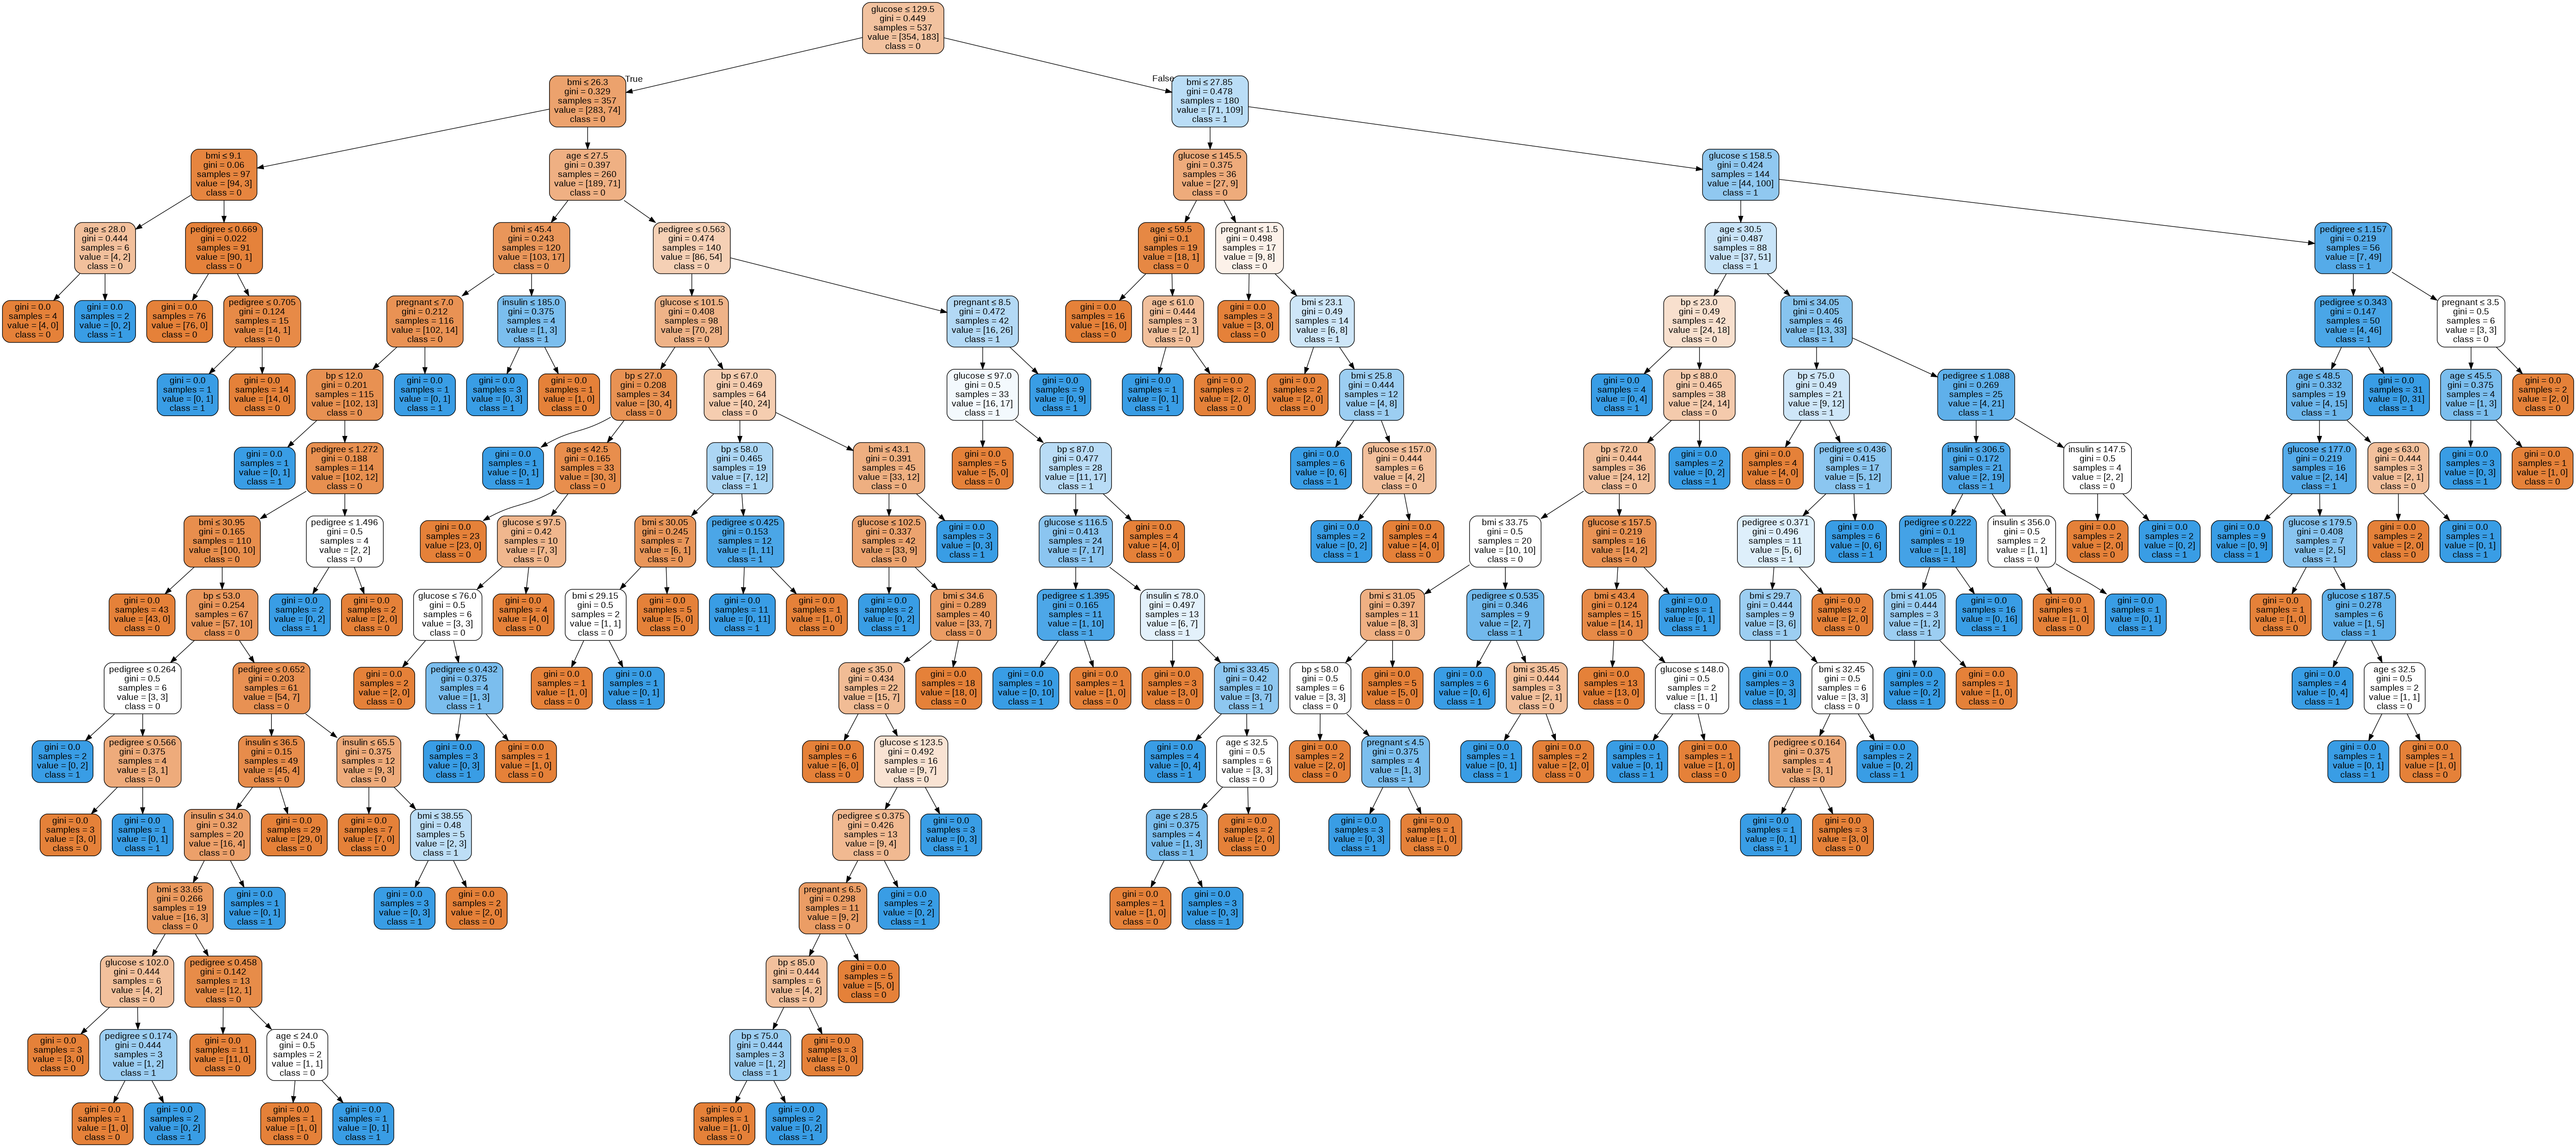

In [ ]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, filled=True, rounded=True, special_characters=True, feature_names=feature_cols, class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())

**b) Naive Bayesian Classifier - Pseudocode**

NaiveBayesianClassifier()
    {
  
    Calculate the prior probability for the given class labels
    calculate the conditional probability with each attribute for each class
    Multiply the same class conditional probability
    Multiply the above with Prior probability
    The input belongs to the class with the highest probability
    }


The Posterior probability :


array([[0.97, 0.03],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.98, 0.02]])

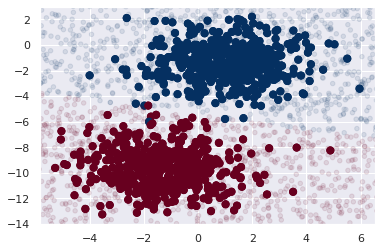

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.datasets import make_blobs
from sklearn.naive_bayes import GaussianNB

X, y = make_blobs(1000, 2, centers=2, random_state=2, cluster_std=1.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu');

model = GaussianNB()
model.fit(X, y);

rng = np.random.RandomState(0)
Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
ynew = model.predict(Xnew)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='RdBu')
lim = plt.axis()
plt.scatter(Xnew[:, 0], Xnew[:, 1], c=ynew, s=20, cmap='RdBu', alpha=0.1)
plt.axis(lim);

print("The Posterior probability :")
yprob = model.predict_proba(Xnew)
yprob[-8:].round(2)